# OCR lab instructions

In this lab you will be experimenting with an OCR pipeline. The OCR software package used is called Tesseract and is open source.

Below, you will find several blocks of python (3) code. The best way of using the code is to copy this notebook and experient in jupyter lab or similar environment. You can get jupyter lab either on your own/chomsky system by downloading the anaconda python distribution. The notebook should also work in google colab, as a fallback solution.

In the text block below, you will find several tasks and questions in bold. These are what I want you to do and answer for the lab report. All answers are your way of arguing to me that you have understood the question/answer. You can hand in your report in traditional lab report format (pdf & latex) or (preferably) a jupyter notebook with your code and reflections as text blocks (you can use this one as a template assuming you remove my text and unnecessary code). 

#### Lab flow and grading criteria

You will analyse an OCR pipeline using given examples and some printed text of your choosing.

__Lab flow:__
* Download the code repo
* Experiment with the notebook
 * Do tasks and answer questions
 * Create/find your own data
* Evaluate the OCR robustness on your data

__Pass:__ A quantitative analysis for how different types of image noise impacts the OCR quality, with and without a language model.

__Pass with distinction:__ In addition to the requirements for a passing grade, a qualitative analysis of OCR on some damaged and/or historical material you find or produce yourself.

## Part 0: Setting up the environment

To be able to use this code, you will need to have the packages opencv (for image loading and manipulation), tqdm (interface niceness), tesseract (for OCR) and pytesseract (the tesseract python bindings) installed. You can install pytesseract by running the following command in your terminal where package_name is the name of the package you want to install. The flag "--user" tells pip3 to only install the package for your account, since you don't have access to /usr on the computers in Chomsky. The main tesseract package must be installed with your package manager, however, it should already be installed in Chomsky.

```
pip3 install [--user] package_name
```

More information can be found at: https://pypi.org/project/pytesseract/

If you are running this in google colab, the following code will set up your environment with the needed libraries.

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  !apt install tesseract-ocr
  !apt install tesseract-ocr-swe
  !pip install pytesseract

The matplotlib module will be used to generate nice plots.

In [2]:
import matplotlib.pyplot as plt # Plotting, the line after this one is only for jupyter notebook
#%matplotlib inline

__Task:__ Below there will be a lot of code. Try to get a _shallow_ understanding of what everything does. You don't have to dig into the libraries but see to it that you understand data structures and interfaces. 

## Part 1: Image data basics

In the lecture, there was several slides about image basics. This part is a demonstration of some of the concepts mentioned there.

With the opencv package you can easily load an image to a python variable. Just as in earlier courses, numpy is used for vector space data (which images can be seen as).

In [3]:
import cv2         # Image loading and manipulation
import numpy as np # Vector math

With opencv (open source computer vision library) installed, loading files is easy.

In [4]:
eisenhower_image = cv2.imread("Eisenhower.png", cv2.IMREAD_GRAYSCALE)
print(eisenhower_image.shape)
print(eisenhower_image.dtype)

(595, 712)
uint8


The variable eisenhower_image is a gray scale image since the cv2.IMREAD_GRAYSCALE argument was passed to the loading function. Note that we can ask eisenhower_image abouts its data type and shape etc. The data type of image data is usually 8-bit non-negative integers, by tradition and that it's practical.

### Showing an image

With the matplotlib package, the image can be viewed directly in the notebook.

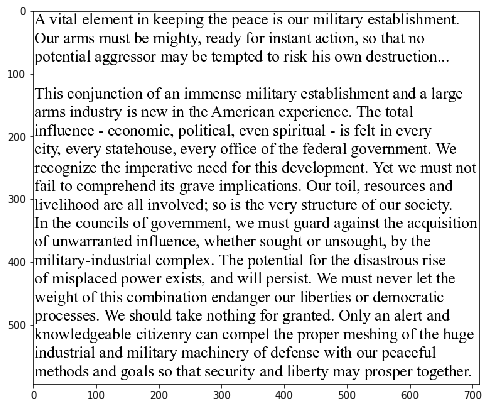

In [5]:
plt.figure(figsize=(8, 8))                # Create a plot
plt.imshow(eisenhower_image, cmap='gray') # Place the image in the plot
plt.show()                                # Show the plot

This is a part of the famous "military industrial complex" speech, which we will use for OCR. The image is made by simply screenshotting a word processor. The image data is as clean as can be with its new times roman, good contrast and large size.

Note that the first axis of the image data is the y-direction (up/down). We can verify this by looking at the dimensions (eisenhower_image.shape) above and compare with the x and y axis in the plot.

The image can be sliced, just as we would be able to with any list or string.

In [6]:
eisenhower_image[5:15, 5:15]

array([[255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 220,  67, 255, 255, 255],
       [255, 255, 255, 255, 255, 108,   0, 209, 255, 255],
       [255, 255, 255, 255, 239,  12,   0,  98, 255, 255],
       [255, 255, 255, 255, 137,  16,   0,   8, 235, 255],
       [255, 255, 255, 251,  29, 188,  17,   0, 132, 255],
       [255, 255, 255, 166,  64, 255, 122,   0,  26, 250],
       [255, 255, 255,  53, 184, 255, 231,   7,   0, 166],
       [255, 255, 194,  49, 255, 255, 255,  99,   0,  55],
       [255, 255,  81, 168, 255, 255, 255, 215,   1,   0]], dtype=uint8)

Note that the background is 255, which is very bright, and the character part we see has lower intensity values, down to 0 (black).

The pixel intesity data shown in the array can be viewed as an image using the following code.

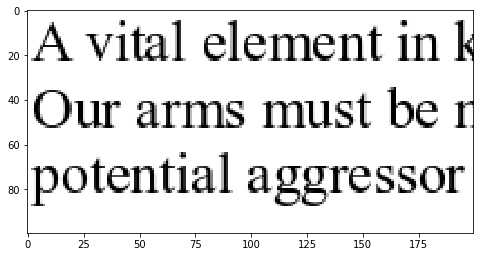

In [7]:
plt.figure(figsize=(8, 8)) # The argument figsize specify the plot size in inches
plt.imshow(eisenhower_image[:100, :200], cmap='gray')
plt.show()

### A bit of traditional image analysis

A connected component is a contiguous blob of pixels.

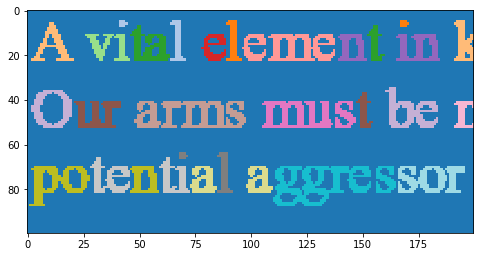

In [8]:
_, cc = cv2.connectedComponents(np.asarray(eisenhower_image[:100, :200]<255, dtype=np.uint8), connectivity=4)

plt.figure(figsize=(8, 8))
plt.imshow(cc, cmap='tab20')
plt.show()

As shown briefly in the slides, we can detect the positions of the text lines quite easily by summing up the number of foreground pixels for each image row. I include it here as an example of traditional image analysis, for nostalgic reasons.

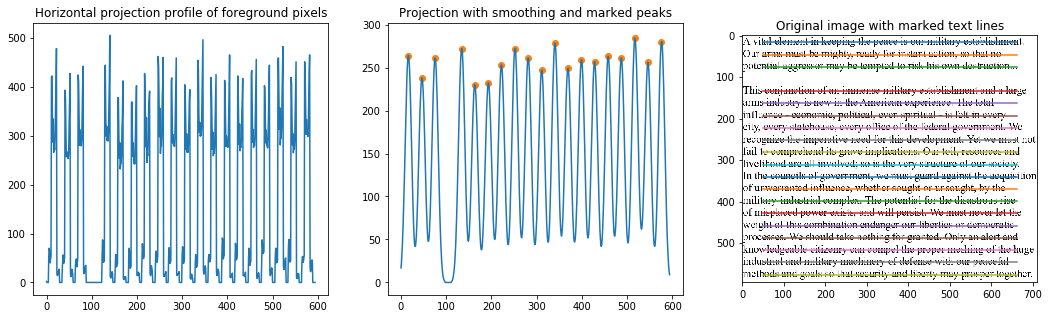

In [9]:
# Set up figure
fig = plt.figure(figsize=(18, 5))
ax = fig.subplots(1, 3)

# Subplot 1
projection = np.sum(eisenhower_image<255, axis=1)

ax[0].plot(projection, 'C0')
ax[0].set_title("Horizontal projection profile of foreground pixels")

# Subplot 2
from scipy.ndimage import gaussian_filter
projection = gaussian_filter(projection, 5, mode='nearest')
from scipy.signal import find_peaks
peaks = find_peaks(projection, distance=10)

ax[1].plot(projection, 'C0')
ax[1].scatter(peaks[0], projection[peaks[0]], c='C1')
ax[1].set_title("Projection with smoothing and marked peaks")

# Subplot 3
ax[2].imshow(eisenhower_image, cmap='gray')
for peak_height in peaks[0]:
    ax[2].plot([50, eisenhower_image.shape[1]-50], [peak_height, peak_height])
ax[2].set_title("Original image with marked text lines")

# Show all
fig.show()

However, in most real world applications, finding the lines will not be this easy.

### Image noise

Noise in this context is everything that might ruin the information we can get from the image. It is a broad term including everything from compression artifacts to mold on the page. In some code blocks below, different types of noise will be shown together with functions for generating them. You will use these functions later.

JPEG compression was designed to remove information that is not needed by the eye for _natural scenes_. It definitely has some good use cases. However, when saving space for digitized archives the compression artifacts can destroy a lot of information.

__Task:__ Try out som values for the quality parameter and see what happens.

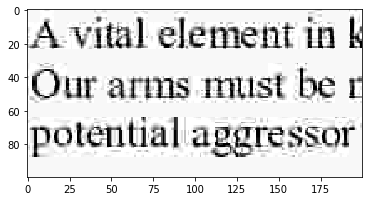

In [10]:
def jpeg_compression(image, quality=95):
    """
    Apply JPEG compression to an image in memory

    Parameters
    ----------
    image : array-like, shape (height, width)
        array representing the image
    quality : Quality level of the compression 0 - 100 (higher is better)

    Returns
    -------
    new_image : array-like, shape (height, width)
    """
    return cv2.imdecode(cv2.imencode(".jpg", image, [cv2.IMWRITE_JPEG_QUALITY, quality])[1], cv2.IMREAD_GRAYSCALE)

img = jpeg_compression(eisenhower_image, quality=5)

plt.figure()
plt.imshow(img[:100, :200], cmap='gray')
plt.show()

Images are often photographed in high resolution and resized into a smaller (more hard drive friendly) size. Since the human eye and brain does not perceive the world as a computer does, this might seem like a good choice. In most cases it will lead to OCR errors due to the lack of clear shapes.

__Task:__ Try out som values for the scale_percent parameter and see what happens.

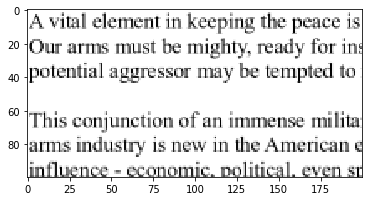

In [11]:
def shrink_image(image, scale_percent=90):
    """
    Reduces the size of the image

    Parameters
    ----------
    image : array-like, shape (height, width)
        array representing the image
    scale_percent : size to scale down the image to 0 - 100

    Returns
    -------
    new_image : array-like, shape (height, width)
    """
    new_width = int(image.shape[1] * scale_percent / 100)
    new_height = int(image.shape[0] * scale_percent / 100)
    return cv2.resize(image, (new_width, new_height), interpolation = cv2.INTER_AREA)

img = shrink_image(eisenhower_image, scale_percent=50)

plt.figure()
plt.imshow(img[:100, :200], cmap='gray')
plt.show()

__Question:__ Which types of noise do you think are most harmful? Any ideas of more types of noise? Make a short list.

## Part 2: OCR

To test and evaluate OCR quality, we will need both an image with text and the text as a python string. 

In [12]:
with open("Eisenhower.txt", 'r') as file:
    original_text = file.read()
original_image = cv2.imread("Eisenhower.png", cv2.IMREAD_GRAYSCALE)

print(original_text[:196])

A vital element in keeping the peace is our military establishment.
Our arms must be mighty, ready for instant action, so that no 
potential aggressor may be tempted to risk his own destruction...


Above is some of the speech from the reference source.

Now on to the OCR. The software package Tesseract is not a python library but can be used via the python library/module pytesseract. After importing these python bindings for tesseract, telling it to decode text in an image is only a function call away. 

In [13]:
import pytesseract # Load OCR software bindings

extracted_text = pytesseract.image_to_string(original_image) # Runs OCR and outputs the result as a python string
print(extracted_text)

A vital element in keeping the peace is our military establishment.
Our arms must be mighty, ready for instant action, so that no
potential aggressor may be tempted to risk his own destruction...

This conjunction of an immense military establishment and a large
arms industry is new in the American experience. The total
influence - economic, political, even spiritual - is felt in every

city, every statehouse, every office of the federal government. We
recognize the imperative need for this development. Yet we must not
fail to comprehend its grave implications. Our toil, resources and
livelihood are all involved; so is the very structure of our society.

In the councils of government, we must guard against the acquisition
of unwarranted influence, whether sought or unsought, by the
military-industrial complex. The potential for the disastrous rise

of misplaced power exists, and will persist. We must never let the
weight of this combination endanger our liberties or democratic
processe

The output looks good. But to be able to compare the OCRed text to the reference (or gold standard) text. We need to define some error metric.

### OCR quality metrics

A common metric of quality of the OCR is the word error rate, i.e. the number of non-recognised words in relation to the total number of words. This can be done by flexibly matching the original text with the text returned from the OCR. Also, a decision must be made for what the total number of words is. Since the errors are assumed to be low, I have used the max length of the two strings to compare after tokenization.

The code shown below uses cython for speed in the Levenshtein calculations. You must have the cython package installed to use this code as it needs to do some compiling on your machine. If this complains about the cython package, install it with pip3 in the same way as the other opencv/pytesseract.

In [14]:
from levenshtein import wer, cer
str1 = "bacon spam spam"
str2 = "spam spam"

print("wer:", wer(str1, str2))
print("cer:", cer(str1, str2))

wer: (1, 0.3333333333333333)
cer: (6, 0.4)


Remember that you can print the doc string for function by doing the following.

In [15]:
print(wer.__doc__)


    Word Error Rate (WER) using Levenshtein distance

    Parameters
    ----------
    lhs : str
    rhs : str

    Returns
    -------
    errors : int
    error_rate: float

    Examples
    --------
    > wer("bacon spam spam", "spam spam")
    (1, 0.3333333333333333)
    


You can also use the Levenshtein code more directly by looking under the hood in levenshtein.py and _levenshtein.pyx.

The tokenization for wer works as follows:

In [16]:
print(original_text.split()[:20])
print(extracted_text.split()[:20])

['A', 'vital', 'element', 'in', 'keeping', 'the', 'peace', 'is', 'our', 'military', 'establishment.', 'Our', 'arms', 'must', 'be', 'mighty,', 'ready', 'for', 'instant', 'action,']
['A', 'vital', 'element', 'in', 'keeping', 'the', 'peace', 'is', 'our', 'military', 'establishment.', 'Our', 'arms', 'must', 'be', 'mighty,', 'ready', 'for', 'instant', 'action,']


In [17]:
we = wer(original_text, extracted_text)
print("Word errors:", we[0])
print("WER:", we[1])

Word errors: 0
WER: 0.0


Becuse of the low error rate, we can say that the OCR was very successfull.

In [18]:
print(list(original_text)[:20])
print(list(extracted_text)[:20])
ce = cer(original_text, extracted_text)
print("Character errors:", ce[0])
print("CER:", ce[1])

['A', ' ', 'v', 'i', 't', 'a', 'l', ' ', 'e', 'l', 'e', 'm', 'e', 'n', 't', ' ', 'i', 'n', ' ', 'k']
['A', ' ', 'v', 'i', 't', 'a', 'l', ' ', 'e', 'l', 'e', 'm', 'e', 'n', 't', ' ', 'i', 'n', ' ', 'k']
Character errors: 16
CER: 0.01263823064770932


You may have noticed that even for this very short text, the CER calculation can take some time. In notebooks, the timeit command is added for benchmarking function execution times.

In [19]:
print("WER time:")
%timeit wer(original_text, extracted_text)
print("CER time:")
%timeit cer(original_text, extracted_text)

WER time:
36.5 ms ± 401 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
CER time:
1.54 s ± 5.12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


__Question:__ What is the relation between the CER and WER. Does WER < CER always hold? Why (not)?

To evaluate the effect of a certain type of noise on the OCR quality, we can test the WER/CER for several values of the noise parameter for each type of noise. This can take some time. Below, the code will test the effect of JPEG compression with quality levels ranging from 1% to 15%. Two language models are used, the default for english and one for swedish.

In [20]:
from tqdm import tqdm # Makes waiting more bearable

quality = list()
WER1 = list()
CER1 = list()
WER2 = list()
CER2 = list()
for q in tqdm(range(1, 15)):
    quality.append(q)
    noisy_image = jpeg_compression(original_image, quality=q)
    extracted_text = pytesseract.image_to_string(noisy_image, lang='eng')
    WER1.append(wer(original_text, extracted_text))
    CER1.append(cer(original_text, extracted_text))
    extracted_text = pytesseract.image_to_string(noisy_image, lang='swe')
    WER2.append(wer(original_text, extracted_text))
    CER2.append(cer(original_text, extracted_text))

100%|██████████| 14/14 [01:18<00:00,  5.53s/it]


Note that in the loop above, all iterations are independent and can be passed to the multiprocessing module. 

Now for plotting the results.

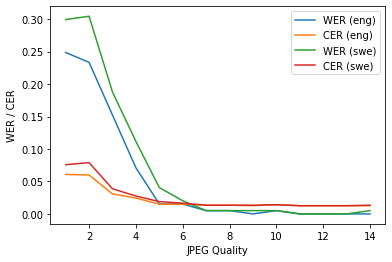

In [21]:
plt.figure()
plt.plot(quality, [e[1] for e in WER1], label="WER (eng)")
plt.plot(quality, [e[1] for e in CER1], label="CER (eng)")
plt.plot(quality, [e[1] for e in WER2], label="WER (swe)")
plt.plot(quality, [e[1] for e in CER2], label="CER (swe)")
plt.xlabel("JPEG Quality")
plt.ylabel("WER / CER")
plt.legend()
plt.show()

__Task:__ Try out the OCR part (whole of part 2) of this lab on the Gutenberg.{txt,png} data (also found in the repo).


# Part 3: Qualitative analysis

For understanding the details on where the OCR pipeline fails, you will need to do some qualitative analysis. The following code will help you by printing information of where a character has been found. 

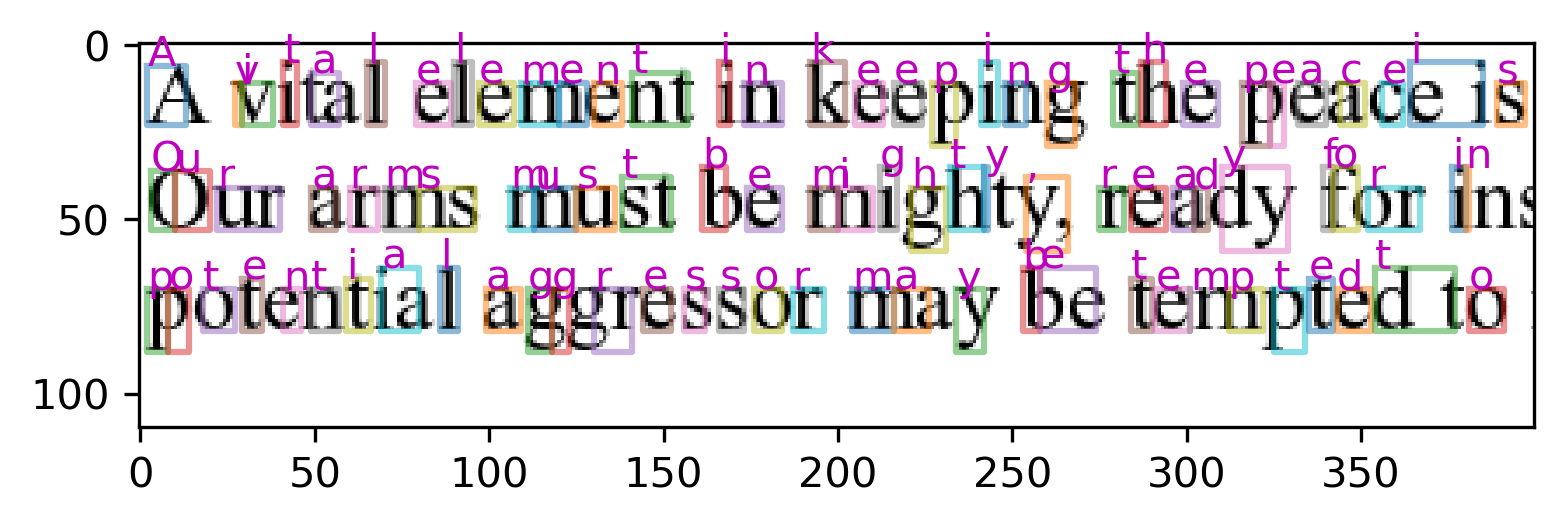

In [22]:
# These parameters can be used to crop the image
#show_y = (0, original_image.shape[0])
show_y = (0, 110)
#show_x = (0, original_image.shape[1])
show_x = (0, 400)

data = pytesseract.image_to_boxes(original_image)
#plt.figure(figsize=(10, 10))
plt.figure(dpi=300)

# TODO Fix offsets
plt.imshow(original_image[show_y[0]:show_y[1], show_x[0]:show_x[1]], cmap='gray')
           #extent=[show_x[0], show_x[1], show_y[0], show_y[1]], cmap='gray')
for entry in data.split("\n"):
    char, a, b, c, d, _ = entry.split()
    assert int(a)<=int(c)
    assert int(b)<=int(d)
    x1 = int(a) - show_x[0]
    x2 = int(c) - show_x[0]
    y1 = original_image.shape[0] - int(d) - show_y[0]
    y2 = original_image.shape[0] - int(b) - show_y[0]
    if show_y[0] <= y1 and y2 <= show_y[1] and show_x[0] <= x1 and x2 <= show_x[1]:
        plt.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], alpha=0.5) # Plot the box
        plt.text(x1, y1, char, color='m')                               # Plot the OCRed character
plt.show()